In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy

# Adding library directory to python search path
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

In [61]:
class consts:
    pi = 3.141592

class setup:
    dummy = 0
    tau_impulse = 100 #мкс для зависимости a_n от nu_n
    T_impulse = 1 #мс для зависимости a_n от nu_n
    nu_error = 1 #кГц погрешность определения частоты меньше не видно :)
    dnu_error = 0.1 # кГц (b16)
    v_error = 5 #мВ погрешность определения амплитуды

In [62]:
data = mipt.read_excel('data/361.xlsx', usecols=(0,1,3,4,6,7,8, 'L', 'M'), header=(0))
data

,v,u,t,dv,m,ab,ao,deltav,T
0,1.2,137.6,200,5.2,10,28,688,1.0,1.00
1,2.2,131.2,180,5.8,20,52,674,2.0,0.50
2,3.2,120.4,160,6.2,30,76,664,3.0,0.33
3,4.2,106.0,140,7.2,40,96,648,4.0,0.25
4,5.2,89.2,120,8.2,50,124,632,0.5,2.00
5,6.2,70.8,100,10.2,60,140,608,0.4,3.00
6,7.2,51.6,80,12.8,70,164,592,NaN,NaN
7,8.2,33.2,60,17.2,80,180,576,NaN,NaN
8,9.2,15.2,40,25.2,90,196,552,NaN,NaN
9,10.2,0.0,20,50.0,100,220,536,NaN,NaN


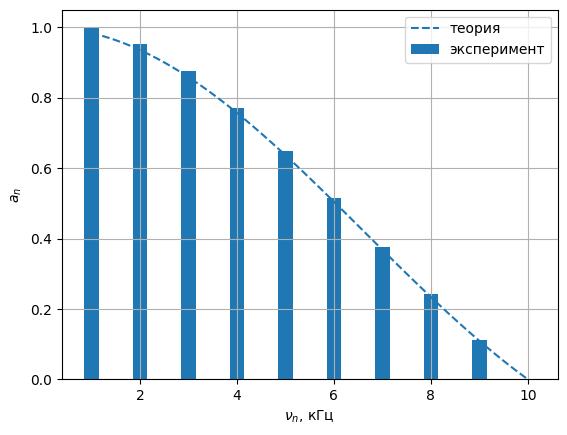

In [63]:
from scipy.interpolate import interp1d
n = np.arange(1, 11, 1)

# x = data['u'][3] * 10 * np.sin(n * consts.pi * setup.tau_impulse * 1e-6/(setup.T_impulse*1e-3)) / (n * consts.pi)

def interp(x, y):
    return interp1d(x, y, kind='cubic')

y = 10 * np.sin(n * consts.pi * setup.tau_impulse * 1e-6/(setup.T_impulse*1e-3)) / (n * consts.pi)
#mipt.plot(n, data['u'], func=None, yerr=setup.v_error)
plt.bar(n, data['u'] / data['u'][0], width = 0.3, label='эксперимент')
mipt.plot(n, y, func=interp, marker_size=0, linestyle='dashed', label='теория')

plt.xlabel(r"$\nu_n$, кГц")
plt.ylabel(r"$a_n$")
plt.grid(True)
plt.legend()
plt.savefig('gen/fig-a9.pdf')




#### A11 Постройте график зависимости Δ𝜈(1/𝜏). Проведите наилучшую прямую и по её наклону убедитесь в справедливости соотношения неопределённостей для длительности импульса и ширины спектра. Оцените погрешность данного опыта

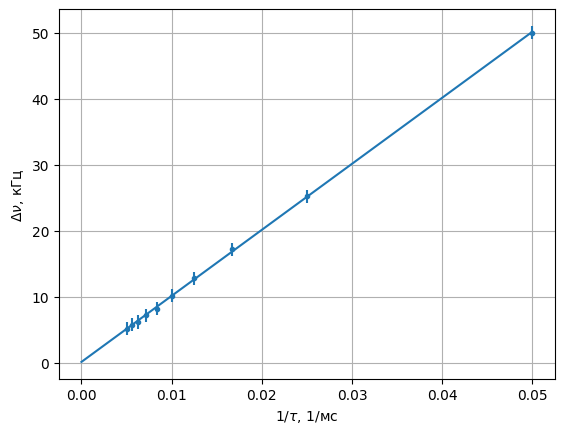

In [64]:
dv = data['dv']
tau = data['t']

x, y, equ = mipt.plot(1/tau, dv, yerr = setup.nu_error, x_min=0)
mnk = mipt.mnk(x,y)
mnk.to_latex('gen/tab-a11-mnk.tex')

plt.xlabel(r"$1/\tau$, 1/мс")
plt.ylabel(r"$\Delta \nu$, кГц")
plt.grid(True)
# plt.legend()
plt.savefig('gen/fig-a11.pdf')


fmt = {
    'dv' : [r'$\Delta\nu$, кГц', '{:.1f}', 0],
    't' :  [r'$\tau$, мс', '{:.0f}', 0],
    '1/tau' :  [r'$\frac{1}{\tau}$, 1/мс', '{:.4f}', 0],
}

dat = pd.concat([dv, tau, (1/tau).rename('1/tau')],axis=1)
tab = mipt.table(dat, fmt)
tab.to_latex('gen/tab-a11.tex')


#### B16 Постройте график зависимости δν(1/T). Проведите наилучшую прямую и сравните результат с теоретическим. Оцените погрешность данного опыта.

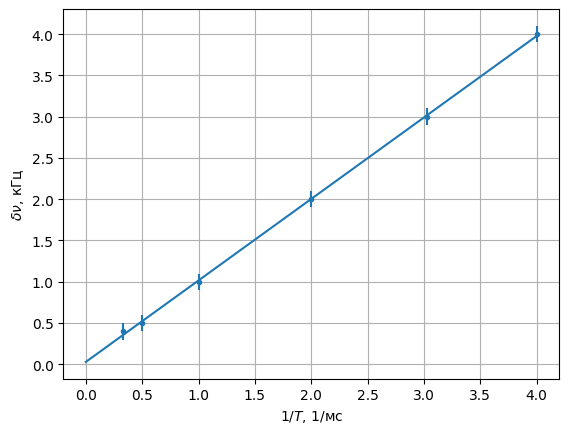

In [72]:
dv = data['deltav'].dropna()
T = data['T'].dropna()

x, y, equ = mipt.plot(1/T, dv, yerr=setup.dnu_error, x_min=0)
mnk = mipt.mnk(x,y)
mnk.to_latex('gen/tab-b16-mnk.tex')

plt.xlabel(r"$1/T$, 1/мс")
plt.ylabel(r"$\delta \nu$, кГц")
plt.grid(True)
# plt.legend()
plt.savefig('gen/fig-b16.pdf')

fmt = {
    'deltav' : [r'$\delta \nu$, кГц', '{:.1f}', 0],
    'T' :  [r'$T$, мс', '{:.2f}', 0],
    '1/T' :  [r'$\frac{1}{T}$, 1/мс', '{:.4f}', 0],
}

dat = pd.concat([dv, T, (1/T).rename('1/T')],axis=1)
tab = mipt.table(dat, fmt)
tab.to_latex('gen/tab-b16.tex')


#### В21 Постройте график зависимости 𝑎бок/𝑎осн от 𝑚. Проведите наилучшую прямую и сравните результат теоретическим. Оцените погрешность данного опыта.


,$\overline{x}$,$\sigma_x^2$,$\overline{y}$,$\sigma_y^2$,$r_{xy}$,$a\cdot10^3$,$\Delta a \cdot10^3$,$b$,$\Delta b$
0,55.0,825.0,0.216197,0.013571,3.342053,0.004051,0.00007,-0.006607,0.00433


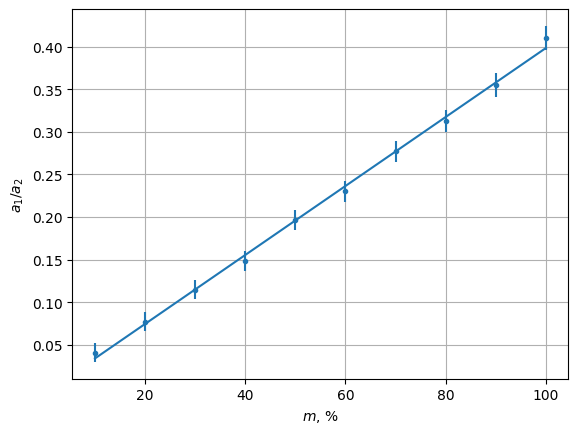

In [76]:
dat = dat = pd.concat([
    data['m'],
    data['ao'],
    data['ab'],
    (data['ab']/data['ao']).rename('bo'),
],axis=1)

x, y, equ = mipt.plot(dat['m'], dat['bo'], yerr = 1.5 * dat['bo'] * setup.v_error / dat['ab'])

mnk_fmt = {
    '<x>':    ['$\overline{x}$', '{:.2e}'],
    'sx':     ['$\sigma_x^2$',   '{:.2e}'],
    '<y>':    ['$\overline{y}$', '{:.2e}'],
    'sy':     ['$\sigma_y^2$',   '{:.2e}'],
    'rxy':    ['$r_{xy}$',       '{:.2e}'],
    'a':      ['$a\cdot10^3$', '{:.2f}', 3],
    'da':     ['$\Delta a \cdot10^3$', '{:.2f}', 3],
    'b':      ['$b$',            '{:.2e}'],
    'db':     ['$\Delta b$',     '{:.2e}'],
}


mnk = mipt.mnk(x,y,fmt=mnk_fmt)
mnk.to_latex('gen/tab-v21-mnk.tex')

plt.xlabel(r"$m$, %")
plt.ylabel(r"$a_1/a_2$")
plt.grid(True)
# plt.legend()
plt.savefig('gen/fig-v21.pdf')

fmt = {
    'm'  : [r'$m$, \%', '{:.0f}', 0],
    'ao' : [r'$a_{\text{осн}}$, мВ', '{:.1f}', 0],
    'ab' : [r'$a_{\text{бок}}$, мВ', '{:.1f}', 0],
    'bo' : [r'$\frac{a_{\text{бок}}}{a_{\text{осн}}}$', '{:.4f}', 0],
}

tab = mipt.table(dat, fmt)
tab.to_latex('gen/tab-v21.tex')
mnk.rename().data